# Elevator Data Model - Citric Sheep

By: Samir Chawla

### Project Summary

The "Elevator Prediction Engine Project" was initiated to devise a model that could predict the most optimal resting floor for an elevator at any given time, leveraging historical demand data. This concept is based on the principle that a stationary, empty elevator's position, termed the "resting floor", ideally should align with the floor from which it's most likely to be summoned next. The project's scope predominantly revolved around modeling the elevator's operations and collecting pertinent data that could subsequently be used to train a machine learning prediction system. Given the diversity in building types – from commercial skyscrapers with multiple high-speed elevators to residential apartments with a single unit – it was pivotal to approach the problem with a clear understanding of the variances. Different buildings not only dictate diverse elevator traffic patterns but also necessitate customized business rules or weights. A large office complex during rush hour would have significantly different elevator demands than a residential building in the early afternoon.

I approached the problem by first understanding the domain thoroughly and then modeling it into a structured storage schema, particularly focusing on an SQLite database. This allowed for efficient CRUD operations. Emphasis was placed on capturing significant data points like the elevator's demand instances, its resting floors, and its movements. The data was structured in a manner that would later facilitate seamless ingestion into a machine learning algorithm. The primary objective was not the completion of the entire system but the establishment of foundational data collection and storage mechanisms that would lead into an ML system. The project additionally demanded the incorporation of meaningful business rules and a keen emphasis on testing to ensure the robustness of the solution. Throughout the process, a clear distinction was maintained between the requirements of senior and junior developers, ensuring that the solutions provided were congruent with the expectations of their respective roles.

### Import Libraries

In [1]:
import pandas as pd
import sqlite3
import random

from eralchemy import render_er
from IPython.display import Image

from flask import Flask, request, jsonify

### Dynamic Business Rules through Reinforcement Learning Optimization

In conventional building management, elevator policies often rely on static business rules based on historical data and recognized usage patterns. While these rules provide a foundation, they might not accommodate nuanced changes in usage or unforeseen events. Our project introduces a shift towards dynamic elevator management using Reinforcement Learning (RL). Beginning with our established business rules as initial "weights" or policies, the RL model constantly learns from ongoing building and elevator usage data. As it interacts with the environment, it refines these rules, aiming to maximize rewards that represent criteria like energy efficiency, user satisfaction, and response times. The result is a more adaptive, efficient, and user-friendly elevator operation system, blending the best of traditional rules with machine learning optimization.

I've integrated the idea that different building types might require different business rules due to their unique characteristics and challenges. This nuanced approach underscores the complexity of the problem and emphasizes a versatile solution.

### Initial Weights or Business Rules

#### Residential Building:
Morning Rush (6am-10am, Monday-Friday, Not a Holiday):

One elevator: Rest at max_floor / 2.
Multiple elevators: Distribute evenly with one elevator at max_floor and another at max_floor / 2.
Evening Rush (3:30pm-6:30pm, Monday-Friday, Not a Holiday):

All elevators should prioritize resting on the ground floor.


#### Commercial Office Building:
Morning Arrival (7am-9am, Monday-Friday, Not a Holiday):

Elevators should be mainly on the ground or parking levels to accommodate incoming employees.
Lunch Time (12pm-2pm, Monday-Friday, Not a Holiday):

One elevator should remain on the ground floor, while others spread out to cater to higher floors.
Evening Departure (4:30pm-6:30pm, Monday-Friday, Not a Holiday):

Elevators should be spread across floors but have a higher presence on ground levels to facilitate employees leaving.


#### Hotel:
Check-in (2pm-6pm, Everyday):

Elevators should be more frequent at the ground and parking levels to facilitate guests checking in.
Check-out (7am-11am, Everyday):

Elevators should prioritize the ground floor for guests checking out.
Night (8pm-12am, Everyday):

Spread evenly as guests might be returning to their rooms from dinners or outings.


#### Hospital:
Hospitals have a consistent flow of people, so elevators should be evenly spread but with a slight emphasis on ground and emergency levels.
Visiting Hours (typically 4pm-8pm):

Elevators should be more available at the ground level at the start and end of visiting hours.


#### Shopping Mall:
Opening Hours (10am-12pm):

Elevators should be primarily on the ground or parking levels.
Closing Hours (8pm-10pm):

Elevators should prioritize ground levels to help shoppers leave.


#### Universities/Schools:
Start of Classes (7:30am-9am, School days):

Elevators should prioritize ground and parking levels.
End of Classes (2pm-4pm, School days):

Elevators should be spread out but with an emphasis on the ground level.

### Elevator Reward Fields Explanation

---

#### 1. `floors_travelled`
**Description**: Represents the total number of floors the elevator has traveled in a specific journey or action. This helps in measuring the efficiency and workload of the elevator.

---

#### 2. `time_to_complete`
**Description**: This denotes the total time taken by the elevator to complete a given task or journey. It helps in evaluating the speed and performance efficiency of the elevator system.

---

#### 3. `energy_consumption`
**Description**: Measures the amount of energy consumed by the elevator during a specific journey. This field is crucial for analyzing the energy efficiency of the elevator and understanding its impact on operational costs.

---

#### 4. `user_wait_time`
**Description**: Represents the duration a user had to wait for the elevator from the moment they made the request until the elevator arrived. It's a crucial metric for assessing user satisfaction and the system's responsiveness.

---

#### 5. `total_reward`
**Description**: A cumulative score derived from the other fields which evaluates the overall performance and efficiency of the elevator for that specific action or journey. A higher reward indicates better performance.


### Build and Design the Database

In [2]:
# Connect to an SQLite database (or create one if it doesn't exist)
conn = sqlite3.connect('elevator_project.db')
cursor = conn.cursor()


# Building Type Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS building_type (
    type_id INTEGER PRIMARY KEY,
    type_name TEXT NOT NULL,
    initial_weights REAL NOT NULL
)
''')

# Building Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS buildings (
    building_id INTEGER PRIMARY KEY,
    building_name TEXT NOT NULL,
    num_floors INTEGER,
    num_elevators INTEGER,
    type_id INTEGER,
    FOREIGN KEY (type_id) REFERENCES building_type (type_id)
)
''')

# Elevator Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS elevators (
    elevator_id INTEGER PRIMARY KEY,
    building_id INTEGER,
    status TEXT DEFAULT 'active',  -- Default value set to 'active'
    FOREIGN KEY (building_id) REFERENCES buildings (building_id)
)
''')


# Elevator Movement Log Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS elevator_log (
    log_id INTEGER PRIMARY KEY,
    elevator_id INTEGER NOT NULL,
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
    demand_floor INTEGER,
    destination_floor INTEGER,
    rest_floor INTEGER,
    FOREIGN KEY (elevator_id) REFERENCES elevators (elevator_id)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS elevator_rewards (
    reward_id INTEGER PRIMARY KEY,
    log_id INTEGER NOT NULL,
    floors_travelled INTEGER,
    time_to_complete REAL,
    energy_consumption REAL,
    user_wait_time REAL,
    total_reward REAL,
    FOREIGN KEY (log_id) REFERENCES elevator_log (log_id)
)
''')


# Commit the changes and close the connection
conn.commit()
conn.close()

### Database Visualization

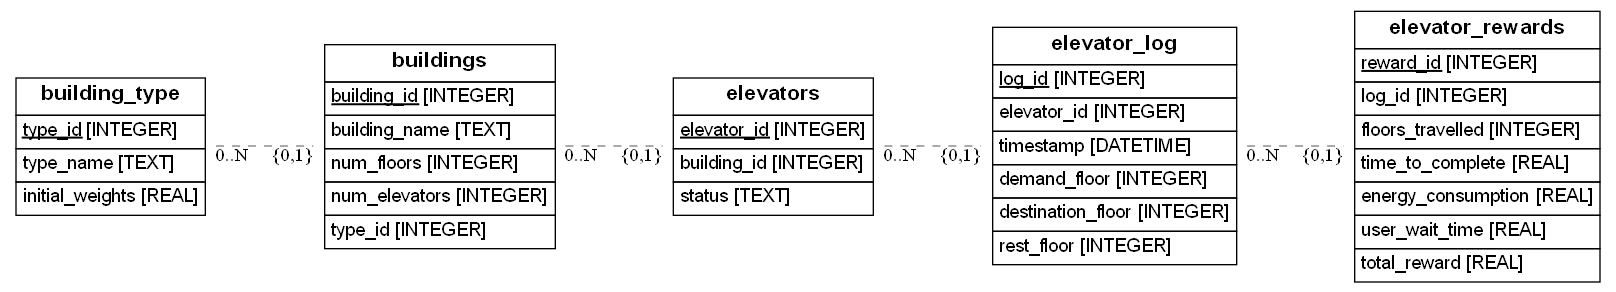

In [3]:
render_er("sqlite:///elevator_project.db", 'db_schema.png')
Image(filename='db_schema.png')

### building_type Data

In [4]:
# Connect to the database
conn = sqlite3.connect('elevator_project.db')  # Change 'your_database_name.db' to the name of your SQLite database
cursor = conn.cursor()


# Sample data for building_type
building_types = [
    ('Residential', 1.0),
    ('Commercial Office Building', 1.5),
    ('Hotel', 2.0),
    ('Hospital', 2.5),
    ('Universities/Schools', 1.2)
]

# Insert data into building_type
cursor.executemany('''
INSERT INTO building_type (type_name, initial_weights) 
VALUES (?, ?)
''', building_types)


# Commit the changes and close the connection
conn.commit()
conn.close()

### building Data

In [5]:
# Connect to the database
conn = sqlite3.connect('elevator_project.db')  # Change 'your_database_name.db' to the name of your SQLite database
cursor = conn.cursor()

# Sample building names
building_names = [
    'Atrium Plaza',
    'Crescent Towers',
    'Silverline Center',
    'Bella Vista',
    'Riverbank Residences',
    'Urban Heights',
    'Plaza Square',
    'Oceanview Apartments',
    'Golden Gate Hotel',
    'Central Hospital',
    'Westside University',
    'Pinnacle Office Park',
    'Hillside Suites',
    'Palm Grove School',
    'Sunrise Commercial Complex'
]

# Randomly populate buildings table with data
building_data = []
for name in building_names:
    type_id = random.choice(range(1, 6))  # As we have 5 types in the building_type table
    
    # Set realistic number of floors and elevators based on building type
    if type_id == 1:  # Residential
        num_floors = random.choice(range(5, 21))
        num_elevators = random.choice(range(1, 4))
    elif type_id == 2:  # Commercial Office Building
        num_floors = random.choice(range(10, 41))
        num_elevators = random.choice(range(2, 8))
    elif type_id == 3:  # Hotel
        num_floors = random.choice(range(8, 26))
        num_elevators = random.choice(range(2, 5))
    elif type_id == 4:  # Hospital
        num_floors = random.choice(range(3, 10))
        num_elevators = random.choice(range(2, 6))
    elif type_id == 5:  # Universities/Schools
        num_floors = random.choice(range(1, 5))
        num_elevators = random.choice(range(1, 3))
    
    building_data.append((name, num_floors, num_elevators, type_id))

# Insert data into buildings
cursor.executemany('''
INSERT INTO buildings (building_name, num_floors, num_elevators, type_id) 
VALUES (?, ?, ?, ?)
''', building_data)

# Commit the changes and close the connection
conn.commit()
conn.close()

### elevators Data

In [6]:
# Connect to the database
conn = sqlite3.connect('elevator_project.db')  # Change 'your_database_name.db' to the name of your SQLite database
cursor = conn.cursor()

# Retrieve the data for each building
cursor.execute("SELECT building_id, num_elevators FROM buildings")
buildings_data = cursor.fetchall()

# Populate the elevators table based on the buildings data
for building in buildings_data:
    building_id = building[0]
    num_elevators = building[1]
    for _ in range(num_elevators):
        cursor.execute("INSERT INTO elevators (building_id) VALUES (?)", (building_id,))

# Commit the changes and close the connection
conn.commit()
conn.close()

In [7]:
# Connect to the database
conn = sqlite3.connect('elevator_project.db')

# Fetch data from building_type table and display it in a pandas DataFrame
building_type_df = pd.read_sql("SELECT * FROM building_type", conn)
print("Building Type Data:")
print(building_type_df)
print("\n" + "-"*50 + "\n")  # Just a separator

# Fetch data from buildings table and display it in a pandas DataFrame
buildings_df = pd.read_sql("SELECT * FROM buildings", conn)
print("Buildings Data:")
print(buildings_df)
print("\n" + "-"*50 + "\n")  # Just a separator

# Fetch data from elevators table and display it in a pandas DataFrame
elevators_df = pd.read_sql("SELECT * FROM elevators", conn)
print("Elevators Data:")
print(elevators_df)

# Close the connection
conn.close()

Building Type Data:
   type_id                   type_name  initial_weights
0        1                 Residential              1.0
1        2  Commercial Office Building              1.5
2        3                       Hotel              2.0
3        4                    Hospital              2.5
4        5        Universities/Schools              1.2

--------------------------------------------------

Buildings Data:
    building_id               building_name  num_floors  num_elevators  \
0             1                Atrium Plaza           2              1   
1             2             Crescent Towers           9              3   
2             3           Silverline Center          18              4   
3             4                 Bella Vista           3              1   
4             5        Riverbank Residences           3              2   
5             6               Urban Heights           6              4   
6             7                Plaza Square           2  

### Endpoints to Collect Data for the Elevator Log and Elevator Rewards

In [8]:
from fastapi import FastAPI, HTTPException, Depends, Header, Body
import threading
from typing import Optional

app = FastAPI()

DATABASE = 'elevator_project.db'
API_KEY = "EPCS-1234567890"
headers = {"Custom-Api-Key": f"Bearer {API_KEY}"}


def get_api_key(custom_api_key_header: Optional[str] = Header(None, alias="Custom-Api-Key")):
    if custom_api_key_header is None:  # and this line
        raise HTTPException(status_code=400, detail="API Key Header missing")

    if not custom_api_key_header.startswith("Bearer ") or custom_api_key_header.split(" ")[1] != API_KEY:  # and this line
        raise HTTPException(status_code=400, detail="Invalid API Key")
    return custom_api_key_header  # and this line



@app.get("/")
async def read_root():
    return {"message": "Welcome to Elevator API"}


@app.post("/elevator_log/")
async def create_elevator_log(
        elevator_id: int = Body(...),
        demand_floor: int = Body(...),
        destination_floor: int = Body(...),
        rest_floor: int = Body(...),
        api_key: str = Depends(get_api_key)
    ):
    try:
        conn = sqlite3.connect(DATABASE)
        cursor = conn.cursor()
        cursor.execute('''
            INSERT INTO elevator_log (elevator_id, demand_floor, destination_floor, rest_floor) 
            VALUES (?, ?, ?, ?)
        ''', (elevator_id, demand_floor, destination_floor, rest_floor))
        conn.commit()
        conn.close()
        return {"status": "success"}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

        
@app.post("/elevator_rewards/")
async def create_elevator_rewards(
        log_id: int = Body(...),
        floors_travelled: int = Body(...),
        time_to_complete: float = Body(...),
        energy_consumption: float = Body(...),
        user_wait_time: float = Body(...),
        total_reward: float = Body(...),
        api_key: str = Depends(get_api_key)
    ):
    try:
        conn = sqlite3.connect(DATABASE)
        cursor = conn.cursor()
        cursor.execute('''
            INSERT INTO elevator_rewards (log_id, floors_travelled, time_to_complete, energy_consumption, user_wait_time, total_reward) 
            VALUES (?, ?, ?, ?, ?, ?)
        ''', (log_id, floors_travelled, time_to_complete, energy_consumption, user_wait_time, total_reward))
        conn.commit()
        conn.close()
        return {"status": "success"}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

        
def run():
    import uvicorn
    uvicorn.run(app, host="127.0.0.1", port=8006)

    
if __name__ == "__main__":
    t = threading.Thread(target=run)
    t.start()

In [9]:
import requests


# Calling the elevator_log endpoint
data_log = {
    "elevator_id": 1,
    "demand_floor": 5,
    "destination_floor": 10,
    "rest_floor": 2
}
response_log = requests.post("http://127.0.0.1:8006/elevator_log/", json=data_log, headers=headers)
print(response_log.json())

# Calling the elevator_rewards endpoint
data_rewards = {
    "log_id": 1,
    "floors_travelled": 5,
    "time_to_complete": 10.5,
    "energy_consumption": 7.5,
    "user_wait_time": 2.5,
    "total_reward": 8.0
}
response_rewards = requests.post("http://127.0.0.1:8006/elevator_rewards/", json=data_rewards, headers=headers)
print(response_rewards.json())

INFO:     Started server process [22032]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8006 (Press CTRL+C to quit)


INFO:     127.0.0.1:58034 - "POST /elevator_log/ HTTP/1.1" 200 OK
{'status': 'success'}
INFO:     127.0.0.1:58035 - "POST /elevator_rewards/ HTTP/1.1" 200 OK
{'status': 'success'}


In [10]:
DATABASE = 'elevator_project.db'

# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)

# Fetch data from elevator_log table
df_elevator_log = pd.read_sql_query("SELECT * from elevator_log", conn)

# Fetch data from elevator_rewards table
df_elevator_rewards = pd.read_sql_query("SELECT * from elevator_rewards", conn)

# Close the database connection
conn.close()

In [11]:
df_elevator_log

,log_id,elevator_id,timestamp,demand_floor,destination_floor,rest_floor
0,1,1,2023-08-28 14:55:01,5,10,2


In [12]:
df_elevator_rewards

,reward_id,log_id,floors_travelled,time_to_complete,energy_consumption,user_wait_time,total_reward
0,1,1,5,10.5,7.5,2.5,8.0


### Dual Reinforcement Learning Models Approach

---

In this elevator optimization scenario, we employ two distinct reinforcement learning (RL) models to make intelligent and efficient decisions:

#### 1. **Elevator Dispatch Model**
**Description**: This RL model determines which specific elevator should respond to a demand. For instance, if there's a request on the 5th floor and multiple elevators are available, this model will decide which elevator is best suited to cater to this request based on various parameters like current location, direction, queue, etc.

---

#### 2. **Elevator Resting Floor Model**
**Description**: After completing its journey or during times of low demand, elevators don't just stay idle. Instead, they move to a 'resting floor' which is strategically decided by this RL model. The model considers various factors like time of the day, historical demand patterns, and the building type (commercial, residential, etc.) to make its decision. This proactive positioning helps in reducing future wait times and enhances system efficiency.

---

Utilizing two models allows for more specialized learning and decision-making for different aspects of the elevator system, ensuring better overall optimization and user satisfaction.


### Next Steps

The successful completion of the technical components lays the groundwork for the crucial phase of implementing and refining the Reinforcement Learning (RL) model for the elevator optimization system. Here are the progressive steps I recommend taking:

#### 1. Setting Up the Simulation Environment
- Before diving into the model, establish a virtual environment that mimics the real-world elevator scenarios. This simulation will allow for safe testing and training of the RL model without disrupting actual elevator operations.

#### 2. Choosing and Implementing the Deep Q-Network (DQN)
- Given the complexity and potential size of the state and action spaces, a DQN is advised as the starting model.
- Utilize popular deep learning frameworks, such as TensorFlow or PyTorch, to implement the neural network architecture for the Q-value approximation.

#### 3. Incorporating Initial Business Rules or "Weights"
- Start the DQN with prior knowledge by integrating the business rules mentioned earlier as initial weights or biases in the model.
- For instance, during morning rush hours in a residential building, you might want to initialize higher Q-values for actions that position elevators at `max_floor / 2` or adjust the neural network biases to favor such actions.

#### 4. Training the Model
- Use the simulation environment to train the DQN model.
- Incorporate a reward function that optimally balances the multiple criteria, such as floors_travelled, time_to_complete, energy_consumption, and user_wait_time.
- Gradually let the model override the initial business rules as it learns from the environment. This dynamic will ensure the model evolves to find optimal strategies that might not have been evident from the preliminary business rules.

#### 5. Intermittent Refinement of Weights
- Monitor the performance metrics of the model in the simulation.
- Intermittently adjust the weights or importance of various metrics like energy consumption or user_wait_time based on observed performance and desired outcomes. This adjustment will allow the system to optimize for the most critical factors at any given time, leading to a more efficient elevator operation.

#### 6. Continuous Learning and Feedback Loop
- After initial training, continuously feed real-world data back into the model to further refine and train it. This process ensures the model remains up-to-date with actual building dynamics and user behavior.

#### 7. Safe Deployment and Monitoring
- Once the model performs satisfactorily in the simulation, deploy it to a test elevator system. Monitor its performance closely to ensure efficiency and safety.
- Gradually roll out to more elevators and eventually the entire building or complex.

#### 8. Iterative Improvements
- As the system runs, continually gather data and feedback. Look for patterns or scenarios where the RL model might not be optimizing well and refine the model accordingly.